In [ ]:
import os
import multiprocessing.dummy as mp

In [2]:

kalimat_base = "data/KalimatCorpus-2.0"
expected_dirs = os.listdir(kalimat_base)

In [3]:
def check_kalimat_structure_os():
    missing = [d for d in expected_dirs if not os.path.isdir(os.path.join(kalimat_base, d))]
    
    if missing:
        print(f"❌ Missing folders: {missing}")
    else:
        count = 0
        for d in expected_dirs:
            folder_path = os.path.join(kalimat_base, d)
            count += len([f for f in os.listdir(folder_path)])
        print(f"✅ Kalimat Corpus is ready with {count} .txt files")

check_kalimat_structure_os()

✅ Kalimat Corpus is ready with 18256 .txt files


In [7]:
def load_kalimat_articles(category):
    category_path = os.path.join(kalimat_base, category)
    if not os.path.isdir(category_path):
        print(f"❌ Category '{category}' does not exist in the Kalimat Corpus.")
        return []

    articles = []
    for filename in os.listdir(category_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(category_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                words = [line.strip() for line in f if line.strip()]
                text = " ".join(words)
                articles.append({
                    "category": category,
                    "filename": filename,
                    "text": text,
                    "word_count": len(words)
                })

    print(f"✅ Loaded {len(articles)} articles from category '{category}'")
    return articles

In [8]:
def load_all_articles_parallel():
    with mp.Pool(processes=min(len(expected_dirs), int(os.cpu_count() / 2))) as pool:
        results = pool.map(load_kalimat_articles, expected_dirs)
    
    dataset = [article for category_articles in results for article in category_articles]
    return dataset

In [ ]:
if __name__ == "__main__": # To solve the multiprocessing issue on Windows
    dataset = load_all_articles_parallel()
    print(f"✅ Dataset loaded with {len(dataset)} articles.")

✅ Loaded 1689 articles from category 'articlesInternational'
✅ Loaded 2495 articles from category 'articlesCulture'
✅ Loaded 3265 articles from category 'articlesEconomy'
✅ Loaded 3237 articles from category 'articlesLocal'
✅ Loaded 3475 articles from category 'articlesReligion'
✅ Loaded 4095 articles from category 'articlesSports'
✅ Dataset loaded with 18256 articles.


In [11]:
import pandas as pd
df = pd.DataFrame(dataset)
df.head()

,category,filename,text,word_count
0,articlesCulture,culturecapr1.txt,كتب سالم الرحبي : تنطلق اليوم الدورة البرامجية...,2732
1,articlesCulture,culturecapr1005.txt,كتب - فيصل العلوي : شاركت السلطنة صباح امس دول...,835
2,articlesCulture,culturecapr1006.txt,اربعة عروض على مسرح الشباب وعرض في الرستاق ثم ...,691
3,articlesCulture,culturecapr1007.txt,حاوره خالد عبداللطيف : حين يناقش الموضوع الثقا...,1972
4,articlesCulture,culturecapr1008.txt,افتتح صباح أمس بقاعة الموسيقي في جامعة السلطان...,329


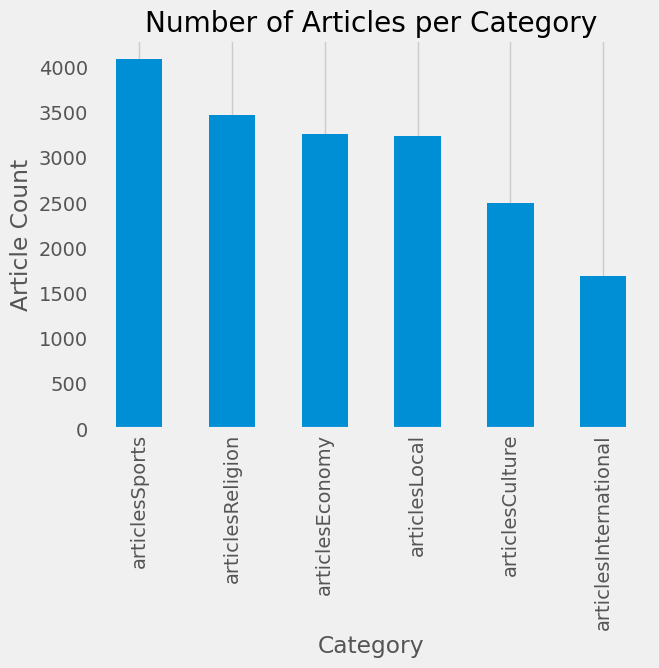

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')  # or 'seaborn', 'fivethirtyeight', etc.

df['category'].value_counts().plot(kind="bar", title="Number of Articles per Category")
plt.xlabel("Category")
plt.ylabel("Article Count")
plt.grid(axis='y')
plt.show()
